(stan-rct-notebook)=
# Incorporare dati storici di controllo in una RCT

Questo capitolo fornisce una trattazione semplificata di un importante problema affrontato da Frank Harrell in un suo intervento intitolato [Incorporating Historical Control Data Into an RCT](https://www.fharrell.com/post/hxcontrol/).

## Preparazione del Notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az
import warnings
from cmdstanpy import cmdstan_path, CmdStanModel

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "stan_rct"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

Nella ricerca psicologica, ci troviamo di fronte a notevoli ostacoli nel reclutare un numero sufficiente di partecipanti per condurre studi controllati randomizzati (RCT), un problema che si acuisce quando si prevede l'assegnazione dei partecipanti a gruppi di controllo che ricevono trattamenti standard. Un'altra difficoltà sorge quando i potenziali partecipanti sono riluttanti a iscriversi agli studi a causa della possibilità di non ricevere il trattamento sperimentale. In questo contesto, l'utilizzo di Dati Storici (HD) per informare su possibili esiti nei gruppi di controllo assume un'importanza vitale. Tuttavia, l'integrazione di tali dati richiede strategie sofisticate per adeguare i bias e le disparità tra i diversi disegni di studio.

Stuart Pocock ha proposto un metodo nel quadro frequentista che valorizza la dimensione campionaria degli HD, pur ammettendo che questi possano riflettere realtà diverse rispetto agli esiti attesi nei gruppi di controllo degli RCT prospettici. La discrepanza include sia la vera performance sconosciuta del gruppo di controllo sia il bias inerente agli HD.

Björn Holzhauer ha ampliato questa visione attraverso lo sviluppo di approcci Bayesiani per l'appropriazione di dati, in particolare riguardo ai tassi di pericolo esponenziali, mediante l'utilizzo di simulazioni MCMC Bayesiane. Queste metodologie consentono l'elaborazione parallela di più modelli e l'inclusione diretta dei dati grezzi degli HD nell'analisi di nuovi dati sperimentali, affrontando direttamente le possibili discrepanze negli oggetti di stima tra HD e RCT.

Una caratteristica fondamentale di queste tecniche è l'aggregazione di dati grezzi da diverse fonti, facilitando un'analisi più precisa che considera l'intero spettro delle incertezze. Questo si contrappone agli approcci tradizionali, che spesso si basano su statistiche riassuntive e tendono a trascurare importanti variabilità, conferendo una fiducia ingiustificata nei dati storici. È, inoltre, cruciale l'ajustamento per covariate al fine di gestire l'eterogeneità degli esiti tra i trattamenti, aumentando così l'affidabilità e l'accuratezza delle stime dell'effetto del trattamento.

Procedendo senza dati diretti per valutare il bias, ci affidiamo a una distribuzione a priori gaussiana con media zero e deviazione standard sigma per descriverlo. Un valore di sigma nullo implica l'assenza di bias, permettendo di integrare gli HD nell'analisi allo stesso livello dei dati di controllo dello studio. Al contrario, un sigma infinito indica una completa ignoranza riguardo al bias, rendendo gli HD non informativi e pertanto trascurabili.

Il focus principale, l'effetto del trattamento delta, viene esaminato più efficacemente attraverso l'analisi di sigma. Un sigma inferiore a 2 rende lo studio informativo su delta, mentre un sigma superiore a 2 può portare a conclusioni errate, specialmente quando gli HD hanno una media artificiosamente gonfiata. Questo sottolinea l'importanza di una scelta accurata dei parametri analitici, in particolare nell'integrazione dei dati storici con quelli dei nuovi studi clinici, per fornire una rappresentazione equilibrata e critica dell'integrazione di tali dati nell'analisi statistica contemporanea.

## Creazione di un Braccio di Controllo con HD

Nel contesto di uno studio RCT condotto con un unico braccio sperimentale, dove i dati di controllo derivano unicamente da controlli storici non contemporanei, la sfida si amplifica. In queste circostanze, il bias intrinseco negli HD non può essere quantificato direttamente. Invece, ci si affida completamente alla distribuzione di incertezza prescelta per il bias. Questo approccio offre un'analisi che, pur essendo paragonabile a una verifica di sensibilità, si avvale del rigoroso quadro analitico Bayesiano. Quest'ultimo, per sua natura flessibile, permette un'estensione naturale a include la meta-analisi di dati individuali dei pazienti e l'adeguamento per covariate, arricchendo così la robustezza e l'affidabilità delle inferenze tratte dallo studio.

In [3]:
stan_file = os.path.join('stan', 'rct.stan')
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> Nb;  // # obs in RCT treatment B
  int<lower=0> Nh;  // # obs in historical control data
  vector[Nb] yb;    // vector of tx=B data
  vector[Nh] yh;    // vector of historical data
  real<lower=0> sigma;  // standard deviation of prior for bias
}
parameters {
  real mua;  // unknown mean for tx=A
  real mub;  // unknown mean for tx=B
  real bias; // unknown bias
}
transformed parameters {
  real delta;
  delta = mua - mub;
}
model {
  yb   ~ normal(mub, 1.0);
  yh   ~ normal(mua + bias, 1.0);
  bias ~ normal(0., sigma);
}




Compiliamo il modello.

In [5]:
model = CmdStanModel(stan_file=stan_file)

In [6]:
Na = 20
Nb = 40
Nh = 500
ya = rng.normal(loc=10, scale=1, size=Na)
yb = rng.normal(loc=5, scale=1, size=Nb)
yh = rng.normal(loc=20, scale=1, size=Nh)

Creiamo il dizionario che contiene i dati richiesti dal modello.

In [7]:
stan_data = {
    "Nb" : Nb, 
    "Nh" : Nh, 
    "yb" : yb, 
    "yh" : yh,
    "sigma" : 1.0
}

Eseguiamo il campionamento MCMC.

In [8]:
fit = model.sample(data=stan_data)

08:26:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:26:17 - cmdstanpy - INFO - CmdStan done processing.


Esaminiamo i risultati ottenuti.

In [9]:
print(fit.summary())

            Mean      MCSE    StdDev         5%         50%        95%  \
lp__  -264.42100  0.033529  1.180120 -266.80300 -264.118000 -263.11200   
mua     19.92330  0.029610  1.005360   18.24820   19.929100   21.63310   
mub      5.20252  0.003843  0.154381    4.95816    5.201830    5.45380   
bias     0.03039  0.029577  1.005080   -1.67966    0.023756    1.70795   
delta   14.72080  0.029912  1.018910   13.03660   14.723300   16.42380   

         N_Eff  N_Eff/s     R_hat  
lp__   1238.85  2236.20  1.002360  
mua    1152.86  2080.97  0.999923  
mub    1614.18  2913.68  1.003060  
bias   1154.77  2084.42  0.999928  
delta  1160.36  2094.51  1.000320  


In [10]:
az.summary(fit, var_names=(["bias", "delta"]), hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bias,0.030,1.005,-1.924,2.019,0.029,0.022,1161.0,1022.0,1.0
delta,14.721,1.019,12.758,16.727,0.030,0.021,1164.0,1051.0,1.0


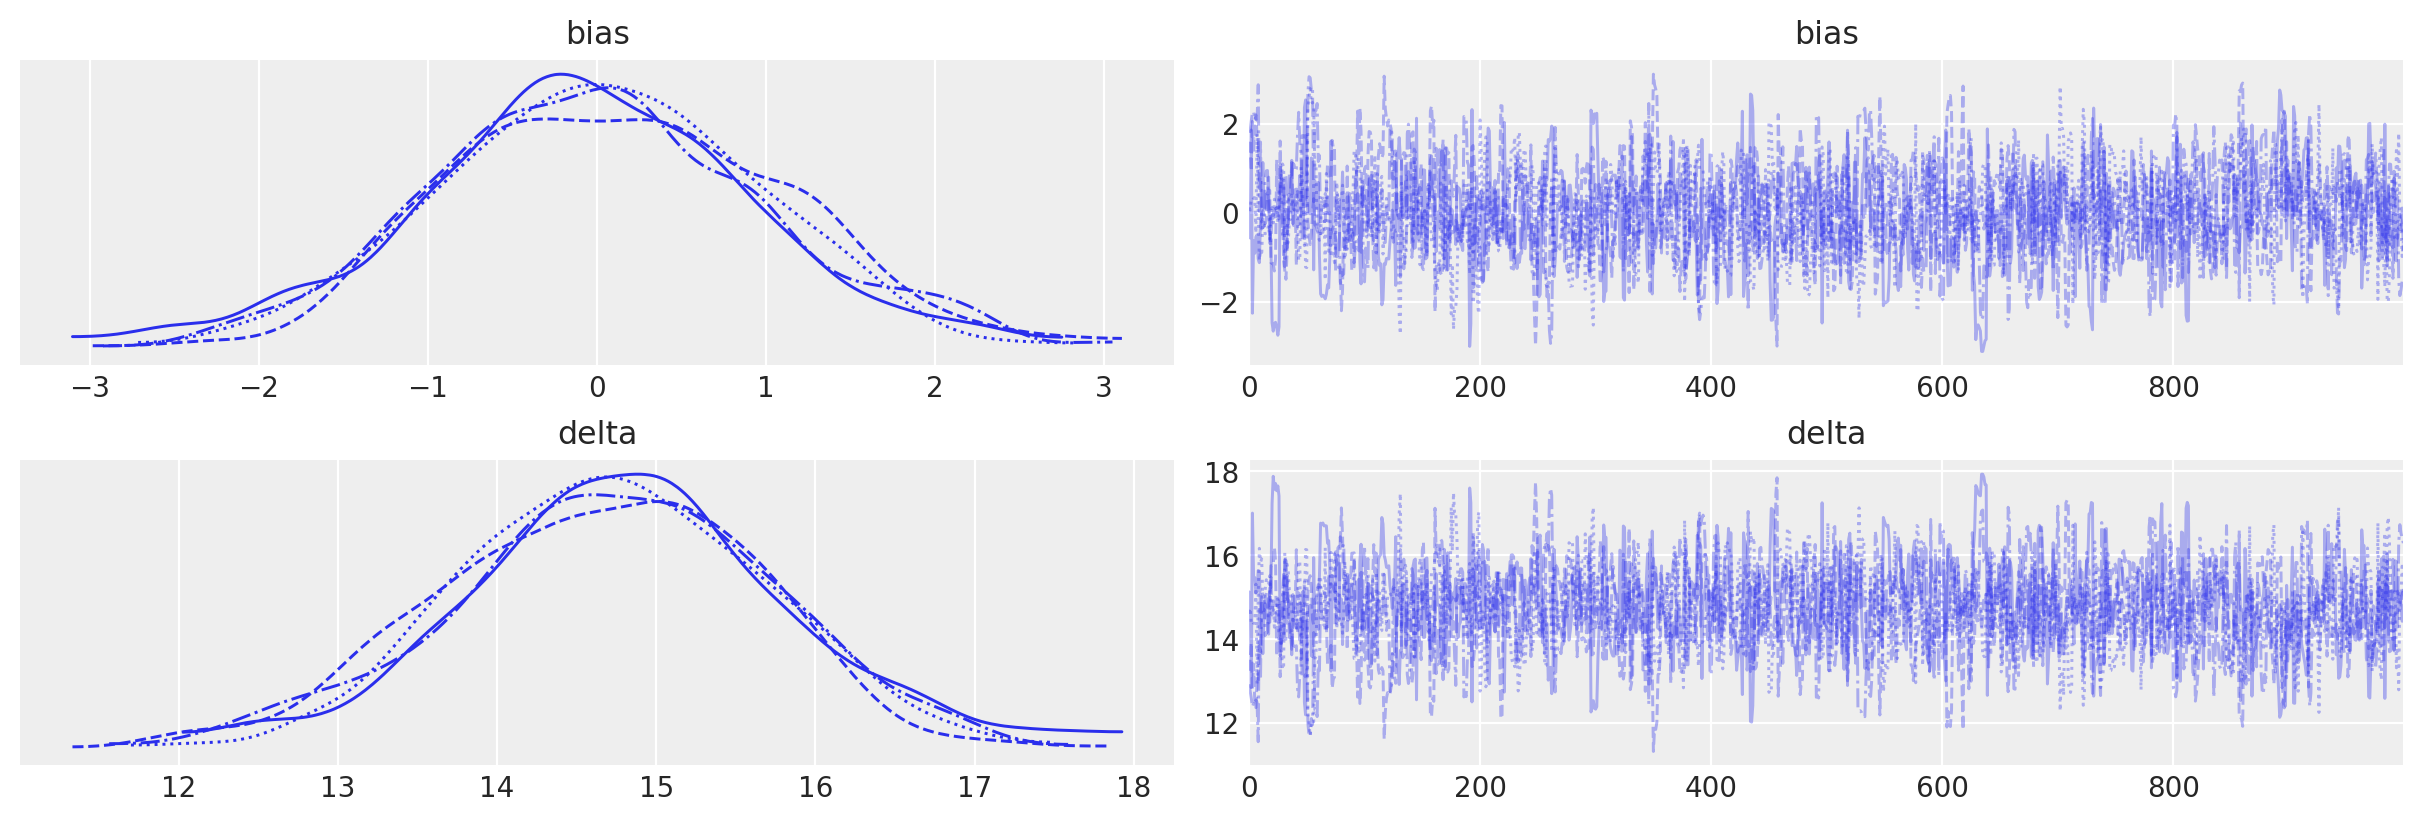

In [10]:
_ = az.plot_trace(fit, var_names=(["bias", "delta"]))

Si noti l'utilità dei dati storici nella riduzione dell'incertezza associata a delta. Quando diminuisce sigma, diminuisce anche l'incertezza associata all'effetto del trattamento.

In [11]:
stan_data = {
    "Nb" : Nb, 
    "Nh" : Nh, 
    "yb" : yb, 
    "yh" : yh,
    "sigma" : 0.25
}

In [12]:
fit1 = model.sample(data=stan_data)

08:26:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:26:28 - cmdstanpy - INFO - CmdStan done processing.


In [13]:
az.summary(fit1, var_names=(["bias", "delta"]), hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bias,0.002,0.249,-0.491,0.479,0.007,0.005,1323.0,1494.0,1.0
delta,14.750,0.295,14.150,15.295,0.008,0.006,1329.0,1409.0,1.0


## Conclusioni

Per stabilire la distribuzione a priori del bias, è fondamentale considerare le informazioni disponibili riguardanti l'evoluzione delle pratiche terapeutiche, il bias di selezione dei pazienti e l'andamento della patologia di interesse. L'approccio Bayesiano ci libera dalla necessità di conoscere con precisione l'entità del bias, indirizzandoci invece a definire la sua distribuzione di incertezza. In caso questa distribuzione sia modellata come gaussiana, ci si avvale dell'ipotesi di simmetria per focalizzarsi sulla deviazione standard, sigma. Un metodo efficace per determinare sigma consiste nel fissarlo in modo che, per esempio, la probabilità che il bias si collochi entro un intervallo di $[-c, c]$ sia del 95%, per poi calcolare retrospettivamente il valore di sigma necessario a soddisfare questa condizione. Questo approccio garantisce una gestione più mirata e scientificamente fondata dell'incertezza legata al bias, fondamentale per l'integrazione ottimale dei dati storici nelle analisi statistiche avanzate.

## Informazioni sull'Ambiente di Sviluppo

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy

Last updated: Thu Jun 13 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

cmdstanpy: 1.2.3

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas    : 2.2.2
scipy     : 1.13.1
matplotlib: 3.8.4
seaborn   : 0.13.2
numpy     : 1.26.4
arviz     : 0.18.0

Watermark: 2.4.3

